In [ ]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import GradientDescentOptimizer, AdamOptimizer, SPSAOptimizer
from pennylane.templates import BasicEntanglerLayers, StronglyEntanglingLayers

# General imports
import numpy as np

from qiskit.quantum_info import SparsePauliOp

import matplotlib.pyplot as plt

from scipy.optimize import differential_evolution

In [2]:
def create_matrix(cut_off, type):
    # Initialize a zero matrix of the specified size
    matrix = np.zeros((cut_off, cut_off), dtype=np.complex128)
    
    # Fill the off-diagonal values with square roots of integers
    for i in range(cut_off):
        if i > 0:  # Fill left off-diagonal
            if type == 'q':
                matrix[i][i - 1] = (1/np.sqrt(2)) * np.sqrt(i)  # sqrt(i) for left off-diagonal
            else:
                matrix[i][i - 1] = (1j/np.sqrt(2)) * np.sqrt(i)

        if i < cut_off - 1:  # Fill right off-diagonal
            if type == 'q':
                matrix[i][i + 1] = (1/np.sqrt(2)) * np.sqrt(i + 1)  # sqrt(i + 1) for right off-diagonal
            else:
                matrix[i][i + 1] = (-1j/np.sqrt(2)) * np.sqrt(i + 1)

    return matrix


# Function to calculate the Hamiltonian
def calculate_Hamiltonian(cut_off, potential):
    # Generate the position (q) and momentum (p) matrices
    q = create_matrix(cut_off, 'q')  # q matrix
    p = create_matrix(cut_off, 'p')  # p matrix

    # Calculate q^2 and q^3 for potential terms
    q2 = np.matmul(q, q)
    q3 = np.matmul(q2, q)

    #fermionic identity
    I_f = np.eye(2)

    #bosonic identity
    I_b = np.eye(cut_off)

    # Superpotential derivatives
    if potential == 'QHO':
        W_prime = q  # W'(q) = q
        W_double_prime = I_b #W''(q) = 1

    elif potential == 'AHO':
        W_prime = q + q3  # W'(q) = q + q^3
        W_double_prime = I_b + 3 * q2  # W''(q) = 1 + 3q^2

    elif potential == 'DW':
        W_prime = q + q2 + I_b  # W'(q) = q + q^2 + 1
        W_double_prime = I_b + 2 * q  # W''(q) = 1 + 2q

    else:
        print("Not a valid potential")
        raise

    # Kinetic term: p^2
    p2 = np.matmul(p, p)

    # Commutator term [b^†, b] = -Z
    Z = np.array([[1, 0], [0, -1]])  # Pauli Z matrix for fermion number
    commutator_term = np.kron(Z, W_double_prime)

    # Construct the block-diagonal kinetic term (bosonic and fermionic parts)
    # Bosonic part is the same for both, hence we use kron with the identity matrix
    kinetic_term = np.kron(I_f, p2)

    # Potential term (W' contribution)
    potential_term = np.kron(I_f, np.matmul(W_prime, W_prime))

    # Construct the full Hamiltonian
    H_SQM = 0.5 * (kinetic_term + potential_term + commutator_term)
    H_SQM[np.abs(H_SQM) < 10e-12] = 0
    
    return H_SQM

In [4]:
# Example usage for a 4x4 matrix
cut_off = 4
#potential = 'QHO'
potential = 'AHO'
H = calculate_Hamiltonian(cut_off, potential)
#Hamiltonian = qml.pauli_decompose(H)
hamiltonian = SparsePauliOp.from_operator(H)

num_qubits = hamiltonian.num_qubits

In [96]:
# Device
dev = qml.device('default.qubit', wires=num_qubits)
#dev = qml.device('lightning.qubit', wires=num_qubits)

# Define the cost function
@qml.qnode(dev)
def cost_function(params):
    params = params.reshape((1, 3, 3))
    #ry_cnot_ansatz(params)
    qml.StronglyEntanglingLayers(weights=params, wires=range(num_qubits), imprimitive=qml.CZ)
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))

In [97]:
scale = 0.5
#params = scale*np.pi*pnp.random.randn(num_qubits, requires_grad=True)
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=num_qubits)
params = scale*np.pi * pnp.random.random(size=params_shape)
params = scale * pnp.random.random(size=params_shape)

In [98]:
params_shape

(1, 3, 3)

In [99]:
# Define bounds for each parameter based on expected ranges (e.g., [0, 2π] for rotation angles)
bounds = [(0, 2 * np.pi) for _ in range(9)]

# Differential Evolution optimization
result = differential_evolution(cost_function, bounds, maxiter=100, strategy='best1bin', popsize=15)
params = result.x  # Extract optimized parameters


In [101]:
stepsize = 0.25
optimizer = AdamOptimizer(stepsize=stepsize) #, beta1=0.99, beta2=0.999, eps=1e-8

In [102]:
# Run the VQE optimization loop
max_iterations = 5000
convergence_tol = 1e-8
prev_energy = None
energies = []


for i in range(max_iterations):
    params, energy = optimizer.step_and_cost(cost_function, params)
    energies.append(energy)
    
    # Print the energy every few steps
    if i % 10 == 0:
        print(f"Iteration {i}: Energy = {energy}")

    # Check for convergence
    if prev_energy is not None and np.abs(energy - prev_energy) < convergence_tol:
        print(f"Converged at iteration {i}")
        break

    prev_energy = energy

print("Final optimized energy:", energy)
print("Optimized parameters:", params)

Iteration 0: Energy = -0.16478526051022124
Converged at iteration 1
Final optimized energy: -0.16478526051022124
Optimized parameters: [1.7834145  3.14158474 4.31495884 6.22493516 0.54069763 6.28318367
 4.26804093 6.28318531 2.28683722]


c:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\.venv\lib\site-packages\pennylane\_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
c:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\.venv\lib\site-packages\pennylane\_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


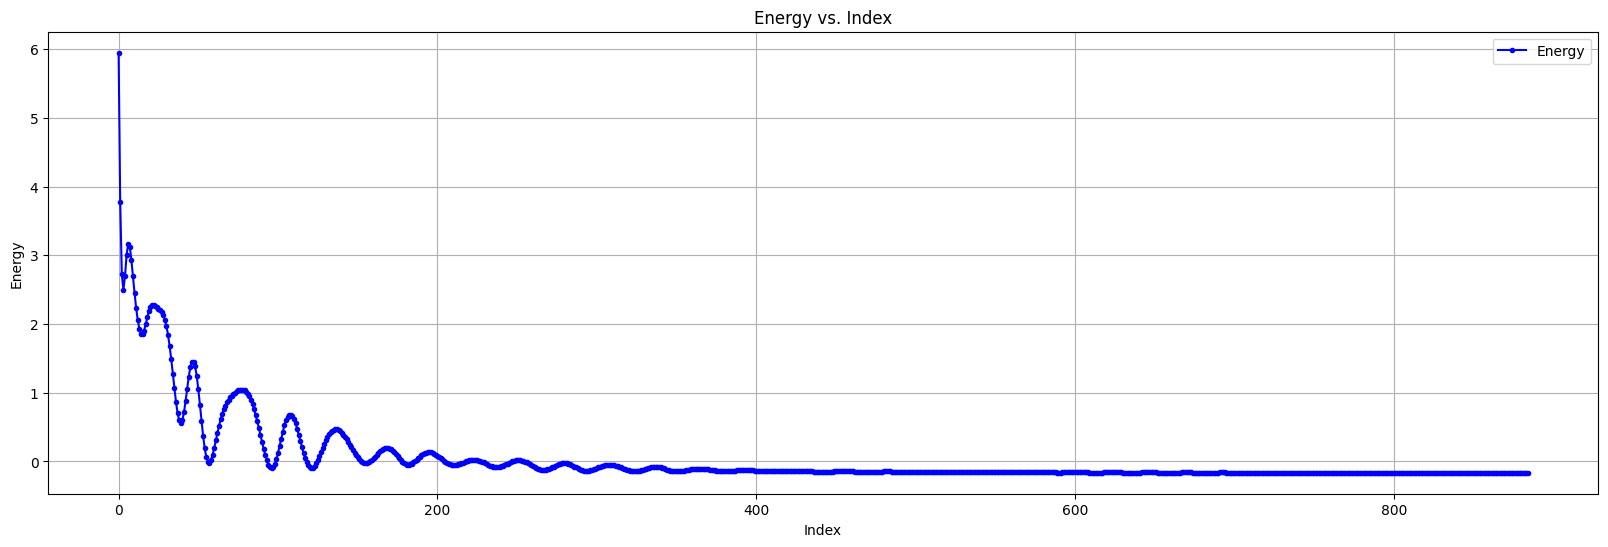

In [51]:
plt.figure(figsize=(20, 6))
plt.plot(energies, marker='.', linestyle='-', color='b', label="Energy")
plt.xlabel("Index")
plt.ylabel("Energy")
plt.title("Energy vs. Index")
plt.grid(True)
plt.legend()
plt.show()